In [36]:
import warnings
from pathlib import Path

import iris
import iris.cube
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

In [37]:
from aeolus.model import um
from aeolus.synthobs import (
    calc_stellar_flux,
    calc_transmission_spectrum,
    calc_transmission_spectrum_day_night_average,
    read_normalized_stellar_flux,
    read_spectral_bands,
)

In [38]:
warnings.filterwarnings("ignore", module="iris")
plt.rcParams["mathtext.default"] = "regular"

In [39]:
# Note that the file paths should be pathlib.Path-like objects, not just plain strings!
DATA_DIR = Path.cwd().parent / "cylc-run" / "u-cp389" / "work" 


In [40]:
SPECTRUM_DIR = Path.cwd().parent.parent.parent / "data" / "dc605" / "For_WASP-96b_Students" 

spectral_file = SPECTRUM_DIR / "spec_file_wasp96b_mdh1_sw_500"
data_file = DATA_DIR / "2hr_mdh1_day" / "atmos_base_0000" / "atmosa.pd00000000_00"
pd0 = iris.load(data_file)

#2hr_mdh1_day/atmos_base_0000

print(pd0)
planet_transmission_day = pd0.extract_cube("m01s01i755")


# To keep the units of stellar and planetary parameters, store the parameters as iris cubes
stellar_constant_at_1_au = iris.cube.Cube(
    1275.359867, units="W m-2", long_name="stellar_constant_at_1_au"
)
stellar_radius = iris.cube.Cube(7.31e8, units="m", long_name="stellar_radius")
planet_radius = iris.cube.Cube(83893200, units="m", long_name="planet_radius")
planet_domain_height = iris.cube.Cube(9737675.52477816, units="m", long_name="height_domain")
planet_top_of_atmosphere = planet_radius + planet_domain_height

0: m01s01i755 / (unknown)              (pseudo_level: 500; time: 2; latitude: 90; longitude: 144)
1: toa_incoming_shortwave_flux / (W m-2) (time: 2; latitude: 90; longitude: 144)
2: toa_outgoing_longwave_flux / (W m-2) (time: 2; latitude: 90; longitude: 144)
3: toa_outgoing_shortwave_flux / (W m-2) (time: 2; latitude: 90; longitude: 144)


In [41]:
read_spectral_bands(spectral_file)[0:4]  # print the first four spectral bands


array([(1, 9.9999997e-05, 9.9999998e-03),
       (2, 4.9999999e-05, 9.9999997e-05),
       (3, 3.3333334e-05, 4.9999999e-05),
       (4, 2.4999999e-05, 3.3333334e-05)],
      dtype=[('spectral_band_index', '<u4'), ('lower_wavelength_limit', '<f4'), ('upper_wavelength_limit', '<f4')])

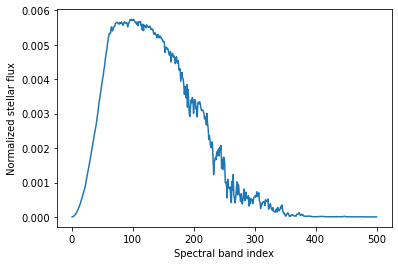

In [42]:
normalized_stellar_flux = read_normalized_stellar_flux(spectral_file)

plt.plot(
    normalized_stellar_flux.coord("spectral_band_index").points,
    normalized_stellar_flux.data,
)
plt.xlabel("Spectral band index")
plt.ylabel("Normalized stellar flux");

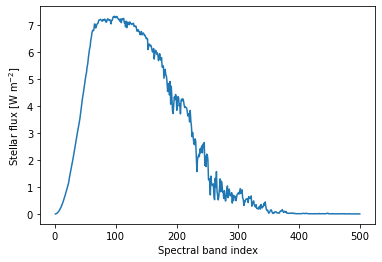

In [43]:
stellar_flux = calc_stellar_flux(spectral_file, stellar_constant_at_1_au)

plt.plot(stellar_flux.coord("spectral_band_index").points, stellar_flux.data)
plt.xlabel("Spectral band index")
plt.ylabel("Stellar flux [W $m^{-2}$]");

In [44]:
planet_transmission_day.shape

(500, 2, 90, 144)

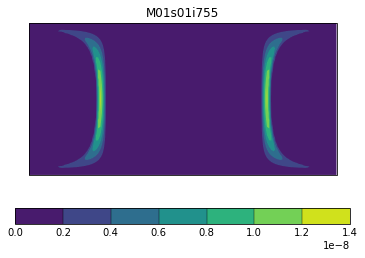

In [45]:
planet_transmission_day_1time = planet_transmission_day[:,1,:,:]

#spectrum_data_1time

#print(spectrum_data.shape)

qplt.contourf(planet_transmission_day_1time[2, ...]);

In [46]:
rp_eff_over_rs = calc_transmission_spectrum(
    planet_transmission_day_1time,
    spectral_file,
    stellar_constant_at_1_au,
    stellar_radius,
    planet_top_of_atmosphere,
    model=um,
)

In [47]:
NIGHT_DIR = Path.cwd().parent / "cylc-run" / "u-cp389" / "work" / "1" / "atmos_base_0000"
night_file = NIGHT_DIR / "atmosa.pd00000000_00"

night_cubes = iris.load(night_file)

#2hr_mdh1_day/atmos_base_0000

planet_transmission_night = night_cubes.extract_cube("m01s01i755")

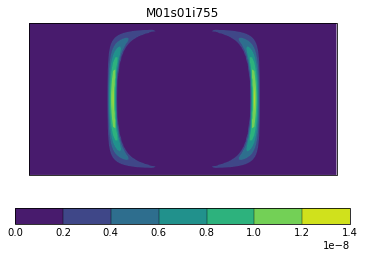

In [48]:
planet_transmission_night_1time = planet_transmission_night[:,1,:,:]

#spectrum_data_1time

#print(spectrum_data.shape)

qplt.contourf(planet_transmission_night_1time[2, ...]);

In [49]:
rp_eff_over_rs_night = calc_transmission_spectrum(
    planet_transmission_night_1time,
    spectral_file,
    stellar_constant_at_1_au,
    stellar_radius,
    planet_top_of_atmosphere,
    model=um,
)

In [50]:
rp_eff_over_rs_dn = calc_transmission_spectrum_day_night_average(
    planet_transmission_day_1time,
    planet_transmission_night_1time,
    spectral_file,
    stellar_constant_at_1_au,
    stellar_radius,
    planet_top_of_atmosphere,
    model=um,
)

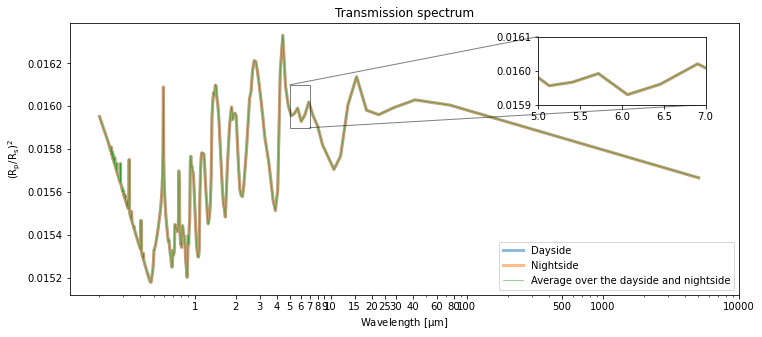

In [66]:
fig, ax = plt.subplots(figsize=(12, 5))
axins = ax.inset_axes([0.7, 0.7, 0.25, 0.25])
axins.set_xlim(5, 7)
axins.set_ylim(0.0159, 0.0161)
for _ax in (ax, axins):
    _ax.plot(
        rp_eff_over_rs.coord("spectral_band_centres").points * 1e6,
        rp_eff_over_rs.data**2,
        label="Dayside",
        linewidth=3,
        alpha=0.5,
    )
    _ax.plot(
        rp_eff_over_rs_night.coord("spectral_band_centres").points * 1e6,
        rp_eff_over_rs_night.data**2,
        label="Nightside",
        linewidth=3,
        alpha=0.5,
    )
    _ax.plot(
        rp_eff_over_rs_dn.coord("spectral_band_centres").points * 1e6,
        rp_eff_over_rs_dn.data**2,
        label="Average over the dayside and nightside",
        linewidth=0.5,
    )

ax.set_title("Transmission spectrum")
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("($R_p/R_s)^2$")
ax.set_xscale("log")

xticks = np.concatenate(
    [
        np.arange(1, 11, 1),
        np.arange(15, 35, 5),
        np.arange(40, 120, 20),
        np.arange(500, 1400, 500),
        np.arange(10000, 10001, 500),
    ]
)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.indicate_inset_zoom(axins, edgecolor="black")
ax.legend(loc="lower right")